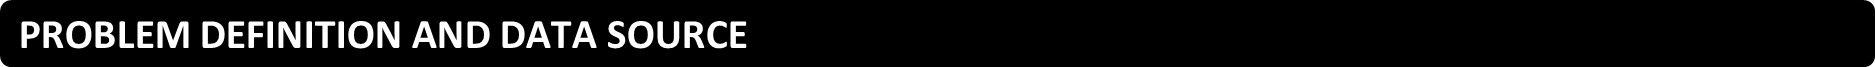

For the present project, we need to perform a real-time analysis of the temperature of several equipment available in a specific company. Each equipment has an identification code and generates logs at regular intervals with some information, including the temperature at which it is operating through sensors.


The idea is to perform a real-time analysis of these logs *(which are generated in txt format)* and identify the equipment that presents an elevated average temperature, since the equipment that exceeds a certain temperature for a long time may have its useful life reduced, generating additional maintenance costs or even the need for equipment replacement.


The Operations Department wishes to have a real-time data analysis solution that calculates the average temperature of each equipment from the data emitted by IoT sensors. Once these devices are identified, we must notify the responsible department via email so that the necessary actions can be taken.

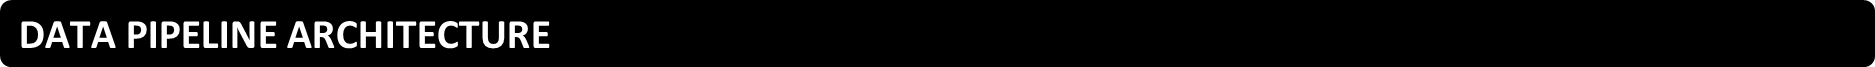

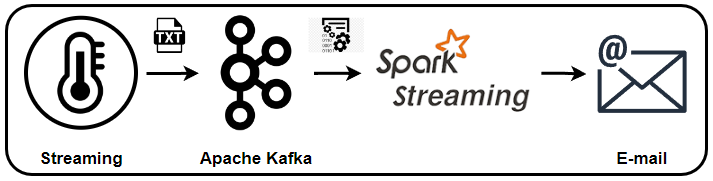

* The **IoT Sensor Data Source (Streaming)** is responsible for generating temperature measurement data from the equipment. It's a txt file.
* The middleware will have **Apache Kafka**, which is responsible for extracting, organizing, and persisting real-time generated data.
* **Spark Streaming** will handle the processing part, where it will convert the data stream and calculate the average temperature per sensor in real-time. It will also be responsible for sending notifications to the responsible department.

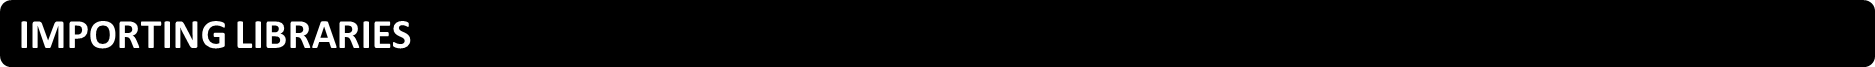

In [1]:
import findspark              # Configures environment for Apache Spark in Python.
import pyspark                # Python interface to Apache Spark for big data processing.
import os                     # Python library for interacting with operating system.
import smtplib                # Python library for sending email messages.
import time, datetime         # Python library for working with time-related tasks.
from email.message            import EmailMessage
from pyspark.streaming        import StreamingContext
from pyspark.sql              import SparkSession
from pyspark.sql.types        import StructType, StructField, StringType, DoubleType
from pyspark.sql.functions    import col, from_json

In [2]:
%reload_ext watermark
%watermark
print('-'*70)
%watermark -a "Thiago Ferreira" --iversions
print('Kafka Version 3.3.1')

Last updated: 2023-03-15T12:07:25.347768-03:00

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.31.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 167 Stepping 1, GenuineIntel
CPU cores   : 12
Architecture: 64bit

----------------------------------------------------------------------
Author: Thiago Ferreira

autopep8 : 1.6.0
findspark: 2.0.1
json     : 2.0.9
pyspark  : 3.3.2

Kafka Version 3.3.1


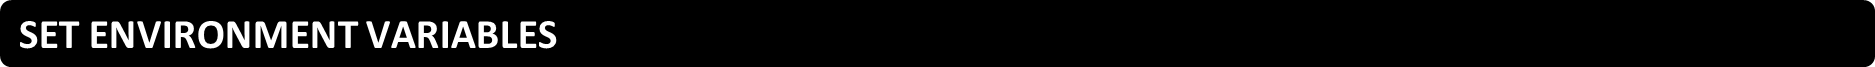

In [3]:
# Creating the environment variable for the Spark Streaming integration connector with Apache Kafka.
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.2 pyspark-shell'

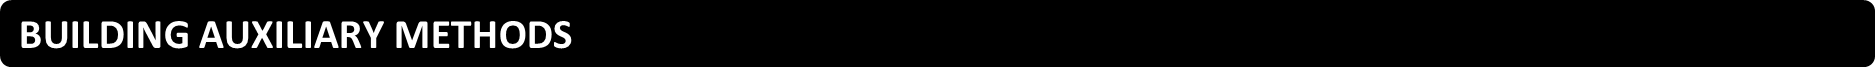

In [4]:
def sendEmail(username: str, password: str, subject: str, destination: list[str], body: str, temp_max: int = 60) -> None:
    """
    Sends an email message using the provided email account credentials.
    Args:
        username (str): The email address of the account sending the email.
        password (str): The password for the email account.
        subject (str): The subject of the email message.
        destination (List[str]): A list of email addresses to send the message to.
        body (str): The body of the email message.
        temp_max (int, optional): The maximum temperature threshold to include in the email body. Defaults to 60.
    Returns:
        None.
    """    
    msg = EmailMessage()
    msg['Subject'] = subject
    msg['From'] = username
    msg['To'] = ', '.join(destination)
    msg.set_content(f"""
    Os seguintes sensores apresentam temperatura acima de {temp_max}ºC.
    
    {body}
    
    Atenciosamente,  
    
    Departamento de Dados.
    """)    
    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
        smtp.login(username, password)
        smtp.send_message(msg)

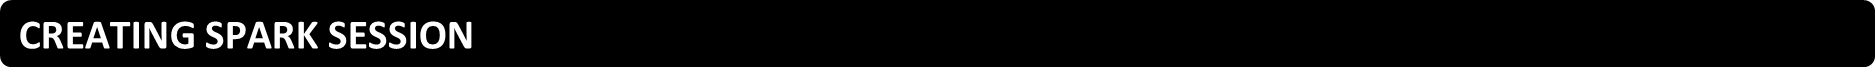

In [5]:
findspark.init()
spark = SparkSession.builder.appName('InfoSensoresProjeto').getOrCreate()

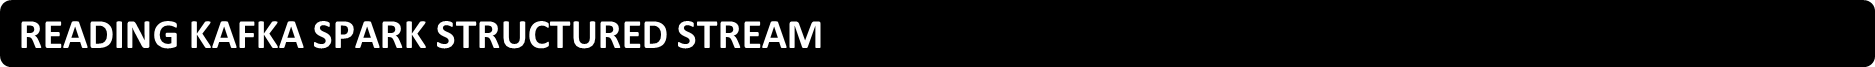

In [6]:
# Creating a subscription to the topic that has the data stream we want to "pull" data from.
df = spark.readStream.format('kafka').option('kafka.bootstrap.servers', 'localhost:9092').option('subscribe', 'sensoresInfos').load()

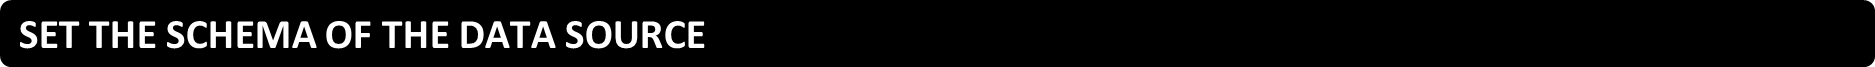

In [7]:
esquema_dados_temp = StructType([StructField('leitura', 
                                             StructType([StructField('temperatura', DoubleType(), True)]), True)])

In [8]:
# Set the schema of the data to capture for analysis (temperature).
data_schema = StructType([ 
    StructField('id_sensor', StringType(), True), 
    StructField('id_equipamento', StringType(), True), 
    StructField('sensor', StringType(), True), 
    StructField('data_evento', StringType(), True), 
    StructField('padrao', esquema_dados_temp, True)])

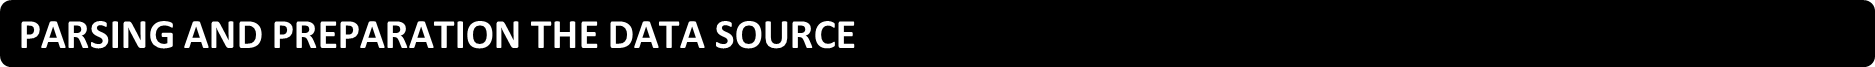

In [9]:
# Data capture and transformation into string.
df_new = df.selectExpr('CAST(value AS STRING)')

In [10]:
# Parsing JSON format into a dataframe.
df_new = df_new.withColumn('jsonData', from_json(col('value'), data_schema)).select('jsonData.*')
df_new.printSchema()

root
 |-- id_sensor: string (nullable = true)
 |-- id_equipamento: string (nullable = true)
 |-- sensor: string (nullable = true)
 |-- data_evento: string (nullable = true)
 |-- padrao: struct (nullable = true)
 |    |-- leitura: struct (nullable = true)
 |    |    |-- temperatura: double (nullable = true)



In [11]:
# Rename the columns.
df_temp_sensor = df_new.select(col('padrao.leitura.temperatura').alias('temperatura'), col('sensor'))
df_temp_sensor.printSchema()

root
 |-- temperatura: double (nullable = true)
 |-- sensor: string (nullable = true)



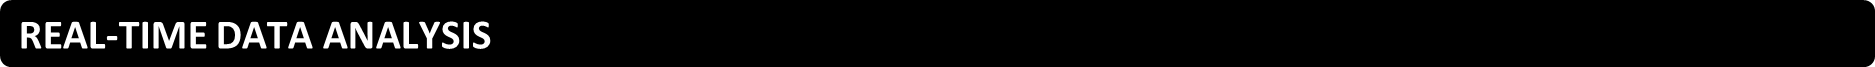

In [12]:
# Grouping of average temperature by sensor.
df_avg_temp_sensor = df_temp_sensor.groupby('sensor').mean('temperatura')
df_avg_temp_sensor.printSchema()

root
 |-- sensor: string (nullable = true)
 |-- avg(temperatura): double (nullable = true)



In [13]:
# Rename the columns.
df_avg_temp_sensor = df_avg_temp_sensor.select(col('sensor').alias('sensor'), col('avg(temperatura)').alias('avg_temp'))
df_avg_temp_sensor.printSchema()

root
 |-- sensor: string (nullable = true)
 |-- avg_temp: double (nullable = true)



In [14]:
# Temp View Memory. Consulting streaming.
query_memoria = df_avg_temp_sensor.writeStream.queryName('querySensores').outputMode('complete').format('memory').start()

In [15]:
# Replace the values below.
email =  str('Sender Email')
password = str('Email Password Key')
listEmails = list['Emails Destination'] 

In [16]:
query_memoria.lastProgress

In [17]:
%%time
# Performs a query on a topic and sends an email to a list if it finds sensors with temperature above a given value.
time
temp = 75
for batch in range(5):   
    time.sleep(60)
    print(f'Batch {batch+1}:')
    info = spark.sql(f'SELECT sensor AS NomeSensor, ROUND(avg_temp, 2) AS MediaTemperatura FROM querySensores WHERE avg_temp > {temp}')    
    
    if info.count() > 0:
        info.show()
        results = info.rdd.map(lambda x: '{} - Temperatura Média: {:.2f}ºC'.format(x.NomeSensor, x.MediaTemperatura)).collect()        
        output = '\n'.join(results)    
        sendEmail(email, password, f'Atenção! {info.count()} sensores com possíveis problemas.', listEmails, output, temp)
        print(f'Email enviado com sucesso para:', *listEmails)
    print(f'Data: {datetime.datetime.now()}')
    print('='*60)   
    

Batch 1:
+----------+----------------+
|NomeSensor|MediaTemperatura|
+----------+----------------+
|  sensor50|           80.04|
|  sensor10|           87.33|
|  sensor24|           81.49|
|  sensor17|           86.21|
|  sensor12|           83.62|
|  sensor15|           83.71|
|  sensor07|           75.04|
|  sensor42|           76.12|
|  sensor46|           85.23|
+----------+----------------+

Email enviado com sucesso para: infosensoreswd@gmail.com
Data: 2023-03-15 12:08:44.725827
Batch 2:
+----------+----------------+
|NomeSensor|MediaTemperatura|
+----------+----------------+
|  sensor17|            85.6|
|  sensor12|           81.59|
|  sensor15|           77.16|
|  sensor22|           76.31|
+----------+----------------+

Email enviado com sucesso para: infosensoreswd@gmail.com
Data: 2023-03-15 12:09:53.943838
Batch 3:
+----------+----------------+
|NomeSensor|MediaTemperatura|
+----------+----------------+
|  sensor15|           78.42|
+----------+----------------+

Email envi

***
Streaming captured three occasions (Batches 1, 2 and 3) out of five in which some sensors presented an average temperature above 75ºC, sending an email to the responsible department.
***

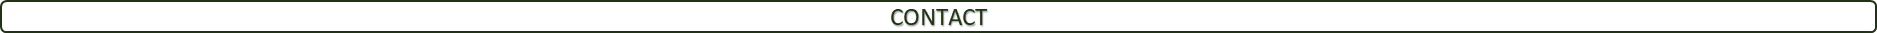

| [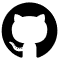](https://www.github.com/ThiagoFerreiraWD) 	| [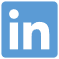](https://www.linkedin.com/in/tferreirasilva) 	| [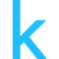](https://www.kaggle.com/thiagoferreirasilva) 	| [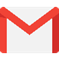](mailto:thiago.ferreirawd@gmail.com) 	| [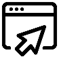](https://thiagoferreirads.com) 	|
|:---:	|:---:	|:---:	|:---:	|:---:	|

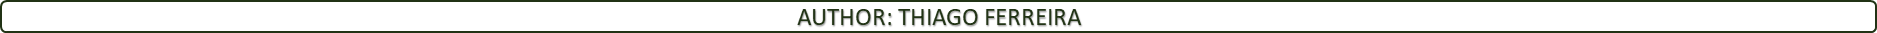